# Testing Camera Attacks

In this notebook we will test the efficacy of several attacks. We will begin with the line drawing attack and move on to the blurring attack. We expect to see a significant decrease in classification accuracy after using these attacks.

After this, we will attempt to boost the classification accuracy.

The classification accuracy of our initial model on the un-altered tests data was over $97\%$

In [2]:
# STDLIB
import os
import typing
import csv
import random
# Packages
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



In [7]:
DATA_DIR = "GTSRB"
TRAINING_DATA_PATH = os.path.join(DATA_DIR, "Final_Training/Images")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


## Line Drawing

This first attack is meant to simulate a crack in the camera lense of the device taking pictures of the traffic signs. 

In [10]:
def minimum_distance(p1, p2):

    i1, i2 = int(p1[0]), int(p2[0])

    # if both x-coordinates are floats and they have the same integer part
    if i1 != p1[0] and i2 != p2[0] and i1 == i2:

        # find the decimal parts
        d1, d2 = p1[0] - i1, p2[0] - i2

        # find the smaller "C"
        x = min(d1 + d2, (1-d1) + (1-d2))

        # add the y distance to the "C" distance
        return abs(p1[1] - p2[1]) + x

    # repeat with the "y-coordinates are floats" case
    i1, i2 = int(p1[1]), int(p2[1])
    if i1 != p1[1] and i2 != p2[1] and i1 == i2:
        d1, d2 = p1[1] - i1, p2[1] - i2
        y = min(d1 + d2, (1-d1) + (1-d2))
        return abs(p1[0] - p2[0]) + y

    # simple case, return the Manhattan distance
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def insert_lines(image) :
    image_data = image
    unmodified_input_image = image_data
    
    #understand the image dimensions
    image_height = image_data.shape[0]
    image_width = image_data.shape[1]
    
    #define the min legth of the line to be drawn on the image
    min_length = round(0.5 * image_height)

    line_length = 0
    iter = 0 
    while (line_length < min_length) and (iter < 10) :
        x = [random.randint(0, image_height), random.randint(0, image_width)]
        y = [random.randint(0, image_height), random.randint(0, image_width)]
        line_length = minimum_distance(x, y)
        iter = iter + 1

    random_col = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    cv.line(image_data, x, y, random_col, 1)

    output_image = cv.addWeighted(image_data, 0.15, unmodified_input_image, 0.85, 0)
    return output_image

In [11]:
def readTrafficSignsTest(rootpath: str) -> typing.Tuple[list[cv.Mat], list[str]]:
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    with open(os.path.join(rootpath, 'GT-final_test.csv')) as gtFile:
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            file_link = os.path.join(rootpath, row[0])
            image = cv.imread(file_link) # read image, the 1th column is the filename
            images.append(image)
            labels.append(row[7]) # the 8th column is the label
    return images, labels

def run_model_on_data(model: keras.Model, images: list[cv.Mat], labels: list[str]) -> dict[str, float]:
    """_summary_: Runs the model on the given images and labels.

    Args:
        model (keras.Model): The model to run on the images.
        images (list[cv.Mat]): The images to run on. These should already be processed.
        labels (list[str]): The labels to run on.

    Returns:
        A dictionary with two keys: 'accuracy' and 'loss'.
    """
    test_images = np.array(images).astype(np.float32) # this allows us to convert it to a tensor
    test_images = test_images/255 # Everyone seems to do this so we will too!!!
    test_labels = np.array(labels).astype(np.float32)

    assert len(test_images) == len(test_labels)

    result = model.evaluate(test_images, test_labels)
    return dict(zip(model.metrics_names, result))


Loading existing model. If you want to retrain, delete the file: cnn_v3.h5
Different Gaussian Sharpening Sigma Values


Text(0.5, 1.0, 'Image With Line')

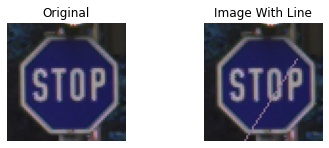

In [12]:
def process_images(images: list[cv.Mat]):
    output = []
    for image in images:
        image_with_line = insert_lines(image)
        resized_image = cv.resize(image_with_line, (32,32)) # resize to 32x32
        output.append(resized_image) # resize to 32x32
    return output

TEST_DATA_PATH = os.path.join(DATA_DIR, "Final_Test/Images")
MODEL_NAME = "cnn_v3.h5"

# Load the Model
model = None
if os.path.exists(MODEL_NAME):
    print("Loading existing model. If you want to retrain, delete the file: " + MODEL_NAME)
    model = keras.models.load_model(MODEL_NAME)
else:
    print("No existing model found.")
    exit(1)

real_test_images, real_test_labels = readTrafficSignsTest(TEST_DATA_PATH)
image_index = 111
print("Different Gaussian Sharpening Sigma Values")
plt.figure(figsize=(10, 10))
plt.subplot(4,3,1)
plt.axis('off')
plt.imshow(real_test_images[image_index])
plt.title("Original")
plt.subplot(4,3, 2)
plt.axis('off')
plt.imshow(insert_lines(real_test_images[image_index]))
plt.title("Image With Line" )

In [13]:
processed_test_images = process_images(real_test_images)
result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

395/395 [==============================] - 2s 5ms/step - loss: 0.4002 - accuracy: 0.9421
{'loss': 0.4001941382884979, 'accuracy': 0.9421219229698181}


### Results

Adding lines to the images after standardizing their size to 32x32 resulted in drop in accuracy to $93.87\%$

Adding lines to the images before standardizing their size to 32x32 resulted in drop in accuracy to $94.6\%$

Different Gaussian Sharpening Sigma Values


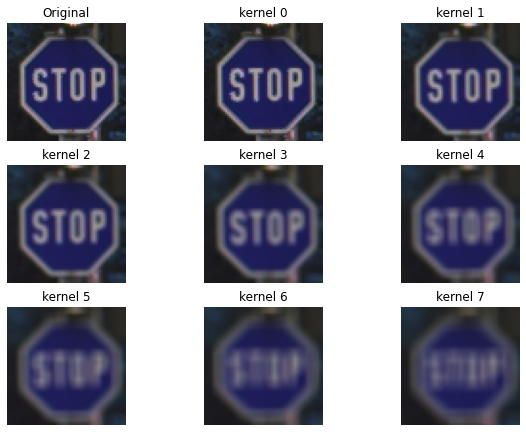

In [17]:
# We have to reread the traffic sign data for some reason because the lines are still there
blur_vals = [1, 2, 3, 4, 5,6,7, 8]
image_index = 111
print("Different Gaussian Sharpening Sigma Values")
plt.figure(figsize=(10, 10))
plt.subplot(4,3,1)
plt.axis('off')
plt.imshow(real_test_images[image_index])
plt.title("Original")
for i, val in enumerate(blur_vals):
    plt.subplot(4,3, i + 2)
    plt.axis('off')
    plt.imshow(cv.blur(real_test_images[image_index], (val, val)))
    plt.title("kernel " + str(i))

In [21]:
def process_images(images: list[cv.Mat]):
    output = []
    for image in images:
        blurred_image = cv.blur(image, (5, 5))
        resized_image = cv.resize(blurred_image, (32,32)) # resize to 32x32
        output.append(resized_image) # resize to 32x32
    return output

TEST_DATA_PATH = os.path.join(DATA_DIR, "Final_Test/Images")
MODEL_NAME = "cnn_v3.h5"

# Load the Model
model = None
if os.path.exists(MODEL_NAME):
    print("Loading existing model. If you want to retrain, delete the file: " + MODEL_NAME)
    model = keras.models.load_model(MODEL_NAME)
else:
    print("No existing model found.")
    exit(1)

real_test_images, real_test_labels = readTrafficSignsTest(TEST_DATA_PATH)
processed_test_images = process_images(real_test_images)

result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

Loading existing model. If you want to retrain, delete the file: cnn_v3.h5
395/395 [==============================] - 2s 5ms/step - loss: 0.9945 - accuracy: 0.8303
{'loss': 0.9944567084312439, 'accuracy': 0.830324649810791}


### Results
The accuracy after blurring the image using a 5x5 pixel mask was $83\%$


In [22]:
def process_images_blur(images: list[cv.Mat]):
    output = []
    for image in images:
        blurred_image = cv.blur(image, (5, 5))
        resized_image = cv.resize(blurred_image, (32,32)) # resize to 32x32
        output.append(resized_image) # resize to 32x32
    return output
def process_images_lines(images: list[cv.Mat]):
    output = []
    for image in images:
        image_with_line = insert_lines(image)
        resized_image = cv.resize(image_with_line, (32,32)) # resize to 32x32
        output.append(resized_image) # resize to 32x32
    return output

def process_images(images: list[cv.Mat]):
    output = []
    for image in images:
        resized_image = cv.resize(image, (32,32)) # resize to 32x32
        output.append(resized_image) # resize to 32x32
    return output

# Find the Accuracy for each of the classes of data
real_test_images, real_test_labels = readTrafficSignsTest(TEST_DATA_PATH)
processed_test_images = process_images(real_test_images)
print("Results for unaltered images")
result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)
blured_images = process_images_blur(real_test_images)
print("Results for Blurred images")
result_dict = run_model_on_data(model, blured_images, real_test_labels)
print(result_dict)
lines_images = process_images_lines(real_test_images)
print("Results for images with lines")
result_dict = run_model_on_data(model, lines_images, real_test_labels)
print(result_dict)

Results for unaltered images

395/395 [==============================] - 2s 5ms/step - loss: 0.1356 - accuracy: 0.9778
{'loss': 0.13562312722206116, 'accuracy': 0.9778305888175964}
Results for unaltered images

395/395 [==============================] - 2s 5ms/step - loss: 0.9945 - accuracy: 0.8303
{'loss': 0.9944567084312439, 'accuracy': 0.830324649810791}
Results for unaltered images

395/395 [==============================] - 2s 5ms/step - loss: 0.4150 - accuracy: 0.9409
{'loss': 0.41497066617012024, 'accuracy': 0.940855085849762}


In [30]:
def gaussian_sharpen(image: cv.Mat, sigma: float = 10) -> cv.Mat:
    """_summary_: Applies gaussian sharpen filter to an image.

    Args:
        image (cv.Mat): The image to be processed.
        sigma (float, optional): The sigma value to be passed to the Gaussian Blur Funtion. Defaults to 3.

    Returns:
        cv.Mat: The processed image.
    """
    blurred_image = cv.GaussianBlur(image, (5,5), sigma)
    return cv.addWeighted(image, 1.5, blurred_image, -0.5, 0)
def sharpen_image_list(images: list[cv.Mat], sigma: float = 1) -> list[cv.Mat]:
    output = []
    for image in images:
        image = gaussian_sharpen(image, sigma)
        output.append(image)
    return output
# Find the Accuracy for each of the classes of data
real_test_images, real_test_labels = readTrafficSignsTest(TEST_DATA_PATH)
processed_test_images = process_images(real_test_images)
print("Results for unaltered images")
sharp_image = sharpen_image_list(processed_test_images)
result_dict = run_model_on_data(model, sharp_image, real_test_labels)
print(result_dict)
blured_images = process_images_blur(real_test_images)
print("Results for Blurred images")
sharp_image = sharpen_image_list(blured_images)
result_dict = run_model_on_data(model, sharp_image, real_test_labels)
print(result_dict)
lines_images = process_images_lines(real_test_images)
print("Results for images with lines")
sharp_image = sharpen_image_list(lines_images)
result_dict = run_model_on_data(model, sharp_image, real_test_labels)
print(result_dict)

Results for unaltered images
395/395 [==============================] - 2s 5ms/step - loss: 0.1227 - accuracy: 0.9801
{'loss': 0.12268727272748947, 'accuracy': 0.980126678943634}
Results for Blurred images
395/395 [==============================] - 2s 4ms/step - loss: 0.9378 - accuracy: 0.8413
{'loss': 0.9378147721290588, 'accuracy': 0.841251015663147}
Results for images with lines
395/395 [==============================] - 2s 4ms/step - loss: 0.4214 - accuracy: 0.9377
{'loss': 0.4213663935661316, 'accuracy': 0.9376880526542664}


The Sharpening did not seem to help accuracy in any of the cases